# Deep Learning for Demand Prediction 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import geopandas
import json
from shapely.geometry import shape
from h3 import h3
from vincenty import vincenty 
from scipy import stats
from keras import models
from keras import layers

Using TensorFlow backend.


In [35]:
# preprocessing / aggregation steps to get demand data 

# read in transformed trip data 
bonn_trips = pd.read_csv("Data/bonn_trips.csv", index_col=0)

# drop columns that were created in Data Preparation / new hexagon resolutions will be created below 
bonn_trips.drop(["h3_hex_id"],axis=1, inplace =True) 

bonn_trips.head()

# set new hex resolution for the prediction 
# therefore the start coordinates of one trip is used 
H3_HEXAGON_RESOLUTION = 7
bonn_trips["h3_hex_id"] = bonn_trips.apply(lambda row: h3.geo_to_h3(row["latitude_start"], row["longitude_start"], H3_HEXAGON_RESOLUTION) if (row['latitude_start'] and row['longitude_start']) else 0, axis=1)

# calculate the centers of the hexagons to use this information for further Support Verctor Regressions 
def centroid(h3hexId):
    vertexes = h3.h3_to_geo_boundary(h3hexId)
    _x_list = [vertex [0] for vertex in vertexes]
    _y_list = [vertex [1] for vertex in vertexes]
    _len = len(vertexes)
    _x = sum(_x_list) / _len
    _y = sum(_y_list) / _len
    return _x, _y

bonn_trips["center"] = bonn_trips["h3_hex_id"].apply(lambda x: centroid(x))
bonn_trips["center_x"] = bonn_trips["center"].apply(lambda x: x[0])
bonn_trips["center_y"]  = bonn_trips["center"].apply(lambda x: x[1])

# returns a time basket 
def get_timebasket(hour):
    #from 5.00 to 10.59 : Morning
    if hour>4 and hour<11:
        x=0        
    #from 11.00 to 12.59 : noon
    if hour>10 and hour<13:
        x=1        
    #from 13.00 to 17.59 : afternoon
    if hour>12 and hour<18:
        x=2        
    #from 18.00 to 22.59 : evening
    if hour>17 and hour<23:
        x=3        
    #from 23.00 to 4.59 : night
    if (hour>22 and hour<25)or hour<5:
        x=4
    return x

bonn_trips['time_basket'] = bonn_trips['hour'].apply(lambda x: get_timebasket(x))

# grouped dataframe by following feature - 
# sums up the number of trips for each hex, month, day, timebasket 
grouped_trips = pd.DataFrame(bonn_trips.groupby(['h3_hex_id','month', 'day',"time_basket", "weekend", "weekday","center_x","center_y"], as_index = False).size())
grouped_trips.rename({0:"Demand"},axis=1, inplace=True )
grouped_trips.reset_index(inplace=True)
#grouped_trips.head()

# grouped dataframe to calculate the mean of the temperatur and the distance to the next station per day and timebasket 
grouped_weather = pd.DataFrame(bonn_trips.groupby(['time_basket', 'h3_hex_id', 'month', 'day'], as_index = False).mean())
grouped_weather.reset_index(inplace=True)
grouped_weather = grouped_weather[['time_basket', 'h3_hex_id', 'month', 'day',"temperature °C","precipitaion_level (mm)","distance_next_station"]]
#grouped_weather

# grouped dataframe to get "precipitation y/n" for the group
grouped_rain_bool = pd.DataFrame(bonn_trips.groupby(['time_basket', 'h3_hex_id', 'month', 'day'], as_index = False).max())
grouped_rain_bool.reset_index(inplace=True)
grouped_rain_bool = grouped_rain_bool[['time_basket', 'h3_hex_id', 'month', 'day',"precipitation y/n"]]
#grouped_rain_bool

# group by hex, month, day and timebasket 
# use the value for the land features that occurs most often within one group
grouped_land_use = pd.DataFrame(bonn_trips.groupby(['h3_hex_id','month', 'day', 'time_basket'], as_index = False)
                                ['urban_fabric', 'discontinuous_urban_fabric', 'continuous_urban_fabric','industry_commercial', 
                                 'green_urban_area', 'agricultural_area', 'forest', 'water_courses'].agg(lambda x:x.value_counts().index[0]))
grouped_land_use.reset_index(inplace=True,drop=True)
grouped_land_use

# merge mean temperature with the demands 
df_demand = grouped_trips.merge(grouped_weather, on=['time_basket', 'h3_hex_id', 'month', 'day'], how="inner")

# merge to get value for precipitation as a boolean value 
df_demand = df_demand.merge(grouped_rain_bool, on=['time_basket', 'h3_hex_id', 'month', 'day'], how="inner")

# merge to get the correct values for the land features
df_demand = df_demand.merge(grouped_land_use,on=['time_basket', 'h3_hex_id', 'month', 'day'], how="inner")

# final dataframe to predict the demand per hexagon, ... 
df_demand["weekend"] = df_demand["weekend"].apply(lambda x : 1 if x else 0)

# fill incorrect values with mean values of the corresponding month
temp_means = df_demand[df_demand["temperature °C"] >= -25].groupby(["month"]).mean()[["temperature °C"]]
for i, row in df_demand.iterrows():     
    if row["temperature °C"] < -25: # lowest temperature in Germany in 2019 was about -20° Celsius 
        df_demand.at[i, "temperature °C"] = temp_means.iloc[row["month"]]        
        
# create new feature for better prediction results 
# distances from the center of the hexagons to the CentralStation / University 
df_demand["distanceToCentralStation"] = df_demand[["center_x","center_y"]].apply(
    lambda x: vincenty([x[0], x[1]], [50.731944, 7.096944]), axis=1)
df_demand["distanceToUniversity"] = df_demand[["center_x","center_y"]].apply(
    lambda x: vincenty([x[0], x[1]], [50.72682, 7.0888]), axis=1)

'\n# read in transformed trip data \nbonn_trips = pd.read_csv("Data/bonn_trips.csv", index_col=0)\n\n# drop columns that were created in Data Preparation / new hexagon resolutions will be created below \nbonn_trips.drop(["h3_hex_id"],axis=1, inplace =True) \n\nbonn_trips.head()\n\n# set new hex resolution for the prediction \n# therefore the start coordinates of one trip is used \nH3_HEXAGON_RESOLUTION = 7\nbonn_trips["h3_hex_id"] = bonn_trips.apply(lambda row: h3.geo_to_h3(row["latitude_start"], row["longitude_start"], H3_HEXAGON_RESOLUTION) if (row[\'latitude_start\'] and row[\'longitude_start\']) else 0, axis=1)\n\n# calculate the centers of the hexagons to use this information for further Support Verctor Regressions \ndef centroid(h3hexId):\n    vertexes = h3.h3_to_geo_boundary(h3hexId)\n    _x_list = [vertex [0] for vertex in vertexes]\n    _y_list = [vertex [1] for vertex in vertexes]\n    _len = len(vertexes)\n    _x = sum(_x_list) / _len\n    _y = sum(_y_list) / _len\n    retur

In [73]:
# Write file so that we don't always have to run the code above
df_demand.to_csv("Data/demand_hex7_timeBaskets")

In [2]:
df_demand = pd.read_csv("Data/demand_hex7_timeBaskets",index_col=0)

In [3]:
df_demand

,h3_hex_id,month,day,time_basket,weekend,weekday,center_x,center_y,Demand,temperature °C,...,discontinuous_urban_fabric,continuous_urban_fabric,industry_commercial,green_urban_area,agricultural_area,forest,water_courses,distanceToCentralStation,distanceToUniversity,isAfternoon
0,871fa1032ffffff,3,3,2,1,6,50.654619,7.214119,3,11.200000,...,0,0,0,0,1,0,0,11.939101,11.955306,1
1,871fa1032ffffff,3,23,3,1,5,50.654619,7.214119,1,8.500000,...,0,0,0,0,1,0,0,11.939101,11.955306,0
2,871fa1032ffffff,3,24,2,1,6,50.654619,7.214119,1,11.000000,...,1,0,0,0,0,0,0,11.939101,11.955306,1
3,871fa1032ffffff,3,25,4,0,0,50.654619,7.214119,1,5.500000,...,1,0,0,0,0,0,0,11.939101,11.955306,0
4,871fa1032ffffff,3,30,2,1,5,50.654619,7.214119,2,18.900000,...,1,0,0,0,0,0,0,11.939101,11.955306,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41311,871fa1c4dffffff,12,31,0,0,1,50.758136,7.045302,6,2.133333,...,1,0,0,0,0,0,0,4.666416,4.643606,0
41312,871fa1c4dffffff,12,31,1,0,1,50.758136,7.045302,7,3.742857,...,1,0,0,0,0,0,0,4.666416,4.643606,0
41313,871fa1c4dffffff,12,31,2,0,1,50.758136,7.045302,17,3.452941,...,1,0,0,0,0,0,0,4.666416,4.643606,1
41314,871fa1c4dffffff,12,31,3,0,1,50.758136,7.045302,20,1.055000,...,1,0,0,0,0,0,0,4.666416,4.643606,0


In [4]:
# feature selection 
X = df_demand[["time_basket","month","center_x","center_y","day", "weekend", "weekday", "temperature °C",
              "distanceToCentralStation","distanceToUniversity","distance_next_station", "urban_fabric",
              "industry_commercial", "green_urban_area"]]
y = df_demand[["Demand"]]
X_train , X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=0)

In [5]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))    
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae','mse'])
    return model

In [6]:
model = build_model()

In [7]:
scaler = StandardScaler()
history = model.fit(scaler.fit_transform(X_train),y_train,epochs=50,batch_size=128,verbose=1)


Epoch 1/50
28921/28921 [==============================] - 1s 29us/step - loss: 1504.6586 - mae: 20.9040 - mse: 1504.6581
Epoch 2/50
28921/28921 [==============================] - 1s 17us/step - loss: 1063.3708 - mae: 16.7030 - mse: 1063.3707
Epoch 3/50
28921/28921 [==============================] - 1s 17us/step - loss: 955.2329 - mae: 15.4457 - mse: 955.2328
Epoch 4/50
28921/28921 [==============================] - 0s 17us/step - loss: 900.7776 - mae: 14.8626 - mse: 900.7775
Epoch 5/50
28921/28921 [==============================] - 1s 19us/step - loss: 868.2003 - mae: 14.4568 - mse: 868.2002
Epoch 6/50
28921/28921 [==============================] - 1s 18us/step - loss: 844.3714 - mae: 14.0710 - mse: 844.3715
Epoch 7/50
28921/28921 [==============================] - 0s 17us/step - loss: 819.6528 - mae: 13.7594 - mse: 819.6533
Epoch 8/50
28921/28921 [==============================] - 1s 18us/step - loss: 788.6194 - mae: 13.3574 - mse: 788.6193
Epoch 9/50
28921/28921 [===================

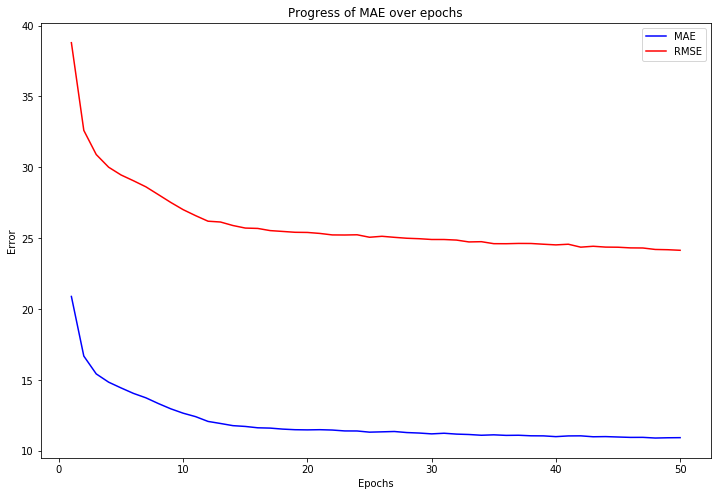

In [8]:
plt.figure(figsize=(12,8))
mae = history.history['mae']
mse = history.history["mse"]
epochs = range(1, len(mae) + 1)
plt.plot(epochs, mae, 'b', label='MAE')
plt.plot(epochs, np.sqrt(mse), 'r', label="RMSE")
plt.title('Progress of MAE over epochs')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

In [12]:
pred = model.predict(scaler.fit_transform(X_train))
print("ON TRAINING DATA:")
print("MAE ", mean_absolute_error(y_train,pred))
print("MSE ", mean_squared_error(y_train,pred))
print("RMSE ", np.sqrt(mean_squared_error(y_train,pred)))
print("R2 ", r2_score(y_train,pred))
print("\n")

pred = model.predict(scaler.fit_transform(X_test))
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("RMSE ", np.sqrt(mean_squared_error(y_test,pred)))
print("R2 ",r2_score(y_test,pred))

ON TRAINING DATA:
MAE  10.74491101677316
MSE  554.7715017511879
RMSE  23.553587874274864
R2  0.7005579942780793


ON TEST DATA:
MAE  11.604687687763047
MSE  535.8801379472192
RMSE  23.149085034774465
R2  0.7063206857813624


###### In comparison to the SVR this first NN returns much better results. Furthermore the NN isn't overfitted. 

<b>Metrics on the first SVR<br></b>
ON TEST DATA <br>
 R2:  	 0.41 <br>
 MAE:  	 14.85 <br>
 MSE:  	 1082.82 <br>
 RMSE:   32.91 <br>

In [65]:
# increase epochs 
model = build_model()
history = model.fit(scaler.fit_transform(X_train),y_train,epochs=100,batch_size=128,verbose=0)
pred = model.predict(scaler.fit_transform(X_train))
print("ON TRAINING DATA:")
print("MAE ", mean_absolute_error(y_train,pred))
print("MSE ", mean_squared_error(y_train,pred))
print("R2 ", r2_score(y_train,pred))
print("\n")

pred = model.predict(scaler.fit_transform(X_test))
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

ON TRAINING DATA:
MAE  9.232994505988934
MSE  282.63063073482175
R2  0.8474480345898457


ON TEST DATA:
MAE  11.023804066704377
MSE  535.0501454792892
R2  0.7067755479819322


--> large number of epochs can lead to overfitting, here it is the case!

In [14]:
# use adam as optimizer
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae','mse'])
    return model

model = build_model()

history = model.fit(scaler.fit_transform(X_train),y_train,epochs=50,batch_size=128,verbose=0)

pred = model.predict(scaler.fit_transform(X_train))
print("ON TRAINING DATA:")
print("MAE ", mean_absolute_error(y_train,pred))
print("MSE ", mean_squared_error(y_train,pred))
print("R2 ", r2_score(y_train,pred))
print("\n")

pred = model.predict(scaler.fit_transform(X_test))
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

ON TRAINING DATA:
MAE  10.260159073673233
MSE  449.1929100793414
R2  0.757544817054157


ON TEST DATA:
MAE  11.219014819911912
MSE  508.1991386934918
R2  0.7214907514398174


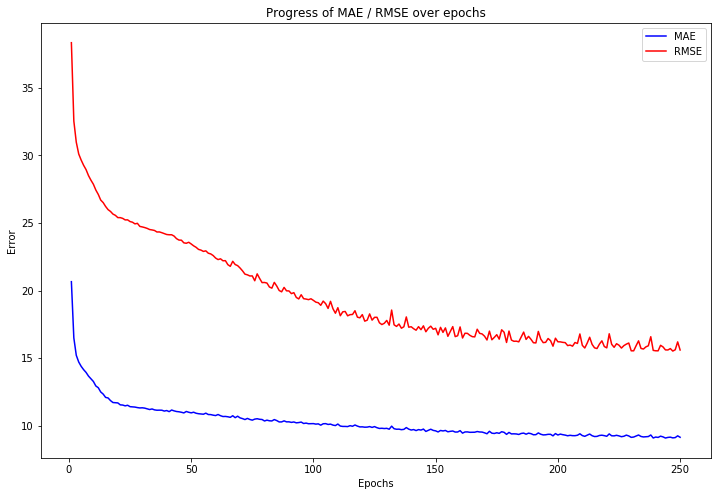

ON TRAINING DATA:
MAE  8.88538229916626
MSE  242.31441121173148
R2  0.8692090111342642


ON TEST DATA:
MAE  10.488954776289868
MSE  479.9525829871241
R2  0.7369707599743036


In [15]:
# drop one hidden layer and see what happens
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(32, activation='relu'))    
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae','mse'])
    return model

model = build_model()
# increase number of epochs 
# decrease batch_size
history = model.fit(scaler.fit_transform(X_train),y_train,epochs=250,batch_size=64,verbose=0)

plt.figure(figsize=(12,8))
mae = history.history['mae']
mse = history.history["mse"]
epochs = range(1, len(mae) + 1)
plt.plot(epochs, mae, 'b', label='MAE')
plt.plot(epochs, np.sqrt(mse), 'r', label="RMSE")
plt.title('Progress of MAE / RMSE over epochs')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

pred = model.predict(scaler.fit_transform(X_train))
print("ON TRAINING DATA:")
print("MAE ", mean_absolute_error(y_train,pred))
print("MSE ", mean_squared_error(y_train,pred))
print("R2 ", r2_score(y_train,pred))
print("\n")

pred = model.predict(scaler.fit_transform(X_test))
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

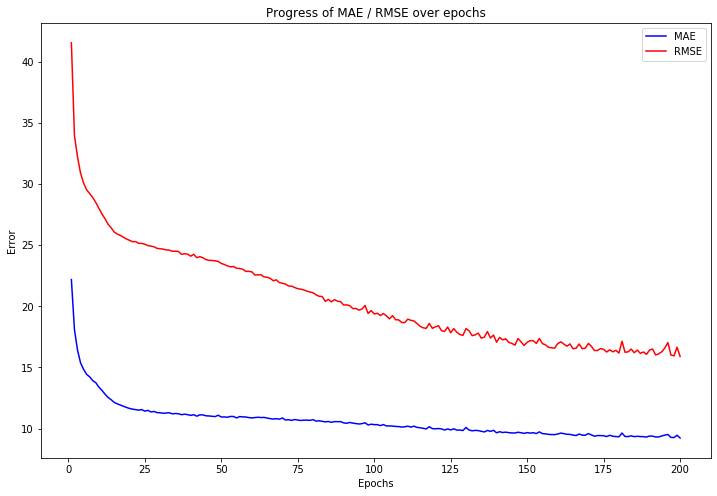

ON TRAINING DATA:
MAE  9.138377569225549
MSE  251.7196890001881
R2  0.8641324431482424


ON TEST DATA:
MAE  10.576623323077682
MSE  457.14188223678383
R2  0.7494717475624391


In [18]:
# drop one hidden layer and see what happens
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(32, activation='relu'))    
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae','mse'])
    return model

model = build_model()

history = model.fit(scaler.fit_transform(X_train),y_train,epochs=200,batch_size=128,verbose=0)

plt.figure(figsize=(12,8))
mae = history.history['mae']
mse = history.history["mse"]
epochs = range(1, len(mae) + 1)
plt.plot(epochs, mae, 'b', label='MAE')
plt.plot(epochs, np.sqrt(mse), 'r', label="RMSE")
plt.title('Progress of MAE / RMSE over epochs')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

pred = model.predict(scaler.fit_transform(X_train))
print("ON TRAINING DATA:")
print("MAE ", mean_absolute_error(y_train,pred))
print("MSE ", mean_squared_error(y_train,pred))
print("R2 ", r2_score(y_train,pred))
print("\n")

pred = model.predict(scaler.fit_transform(X_test))
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

# Further tests 

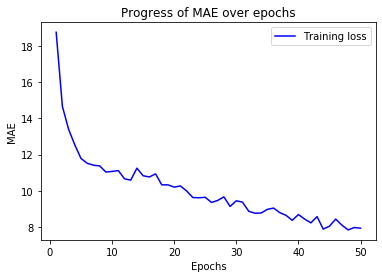

In [33]:
# illustrate a overfitted network 
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))    
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))  
    model.add(layers.Dense(64, activation='relu'))    
    model.add(layers.Dense(64, activation='relu'))    
    model.add(layers.Dense(64, activation='relu'))    
    model.add(layers.Dense(64, activation='relu'))    
    model.add(layers.Dense(32, activation='relu'))    
    model.add(layers.Dense(32, activation='relu'))    
    model.add(layers.Dense(32, activation='relu'))    
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae','mse'])
    return model

model = build_model()
history = model.fit(X_train,y_train,epochs=50,batch_size=128,verbose=0)

mae = history.history['mae']
#val_loss = history.history['val_loss']
epochs = range(1, len(mae) + 1)
plt.plot(epochs, mae, 'b', label='Training loss')
plt.title('Progress of MAE over epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [34]:
pred = model.predict(X_train)
print("ON TRAINING DATA:")
print("MAE ", mean_absolute_error(y_train,pred))
print("MSE ", mean_squared_error(y_train,pred))
print("R2 ", r2_score(y_train,pred))
print("\n")

pred = model.predict(X_test)
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

ON TRAINING DATA:
MAE  8.813754698563354
MSE  299.9759541000602
R2  0.8380857685001364


ON TEST DATA:
MAE  11.084534361459594
MSE  560.0836602757984
R2  0.6930563877867375


--> We can see clearly that a really dense network with many hidden layers tend to overfit. 

# Varying Hexagon resolution and periods

In [19]:
# read in transformed trip data 
bonn_trips = pd.read_csv("Data/bonn_trips.csv", index_col=0)

# drop columns that were created in Data Preparation / new hexagon resolutions will be created below 
bonn_trips.drop(["h3_hex_id"],axis=1, inplace =True) 

In [20]:
def centroid(h3hexId):
    vertexes = h3.h3_to_geo_boundary(h3hexId)
    _x_list = [vertex [0] for vertex in vertexes]
    _y_list = [vertex [1] for vertex in vertexes]
    _len = len(vertexes)
    _x = sum(_x_list) / _len
    _y = sum(_y_list) / _len
    return _x, _y

# function to prepare/aggregate the demand data regarding to the hex_resolution and period_length
def prepareDemandData(hex_resolution=8, periodLength=6, trips=bonn_trips): 
    """
    periodLength = 24h / 6h / 2h / 1h
    hex_resolution = 5 / 6 / 7 / 8 / 9 
    """
    trips["h3_hex_id"] = trips.apply(lambda row: h3.geo_to_h3(row["latitude_start"], row["longitude_start"], 
                                                                        hex_resolution) if (row['latitude_start'] and row['longitude_start']) else 0, axis=1)
    
    trips["center"] = trips["h3_hex_id"].apply(lambda x: centroid(x))
    trips["center_x"] = trips["center"].apply(lambda x: x[0])
    trips["center_y"]  = trips["center"].apply(lambda x: x[1])
    
    trips['time_basket'] = trips['hour'].apply(lambda x: x//periodLength+1)
    
    # grouped dataframe by following feature - 
    # sums up the number of trips for each hex, month, day, timebasket 
    grouped_trips = pd.DataFrame(trips.groupby(['h3_hex_id','month', 'day',"time_basket", "weekend", "weekday","center_x","center_y"], as_index = False).size())
    grouped_trips.rename({0:"Demand"},axis=1, inplace=True )
    grouped_trips.reset_index(inplace=True)

    # grouped dataframe to calculate the mean of the temperatur and the distance to the next station per day and timebasket 
    grouped_weather = pd.DataFrame(trips.groupby(['time_basket', 'h3_hex_id', 'month', 'day'], as_index = False).mean())
    grouped_weather.reset_index(inplace=True)
    grouped_weather = grouped_weather[['time_basket', 'h3_hex_id', 'month', 'day',"temperature °C","precipitaion_level (mm)","distance_next_station"]]

    # grouped dataframe to get "precipitation y/n" for the group
    grouped_rain_bool = pd.DataFrame(trips.groupby(['time_basket', 'h3_hex_id', 'month', 'day'], as_index = False).max())
    grouped_rain_bool.reset_index(inplace=True)
    grouped_rain_bool = grouped_rain_bool[['time_basket', 'h3_hex_id', 'month', 'day',"precipitation y/n"]]
    
    # group by hex, month, day and timebasket 
    # use the value for the land features that occurs most often within one group
    grouped_land_use = pd.DataFrame(trips.groupby(['h3_hex_id','month', 'day', 'time_basket'], as_index = False)
                                    ['urban_fabric', 'discontinuous_urban_fabric', 'continuous_urban_fabric','industry_commercial', 
                                     'green_urban_area', 'agricultural_area', 'forest', 'water_courses'].agg(lambda x:x.value_counts().index[0]))
    grouped_land_use.reset_index(inplace=True,drop=True)

    # merge mean temperature with the demands 
    df_demand = grouped_trips.merge(grouped_weather, on=['time_basket', 'h3_hex_id', 'month', 'day'], how="inner")

    # merge to get value for precipitation as a boolean value 
    df_demand = df_demand.merge(grouped_rain_bool, on=['time_basket', 'h3_hex_id', 'month', 'day'], how="inner")

    # merge to get the correct values for the land features
    df_demand = df_demand.merge(grouped_land_use,on=['time_basket', 'h3_hex_id', 'month', 'day'], how="inner")

    # final dataframe to predict the demand per hexagon, ... 
    df_demand["weekend"] = df_demand["weekend"].apply(lambda x : 1 if x else 0)

    # fill incorrect values with mean values of the corresponding month
    temp_means = df_demand[df_demand["temperature °C"] >= -25].groupby(["month"]).mean()[["temperature °C"]]
    for i, row in df_demand.iterrows():     
        if row["temperature °C"] < -25: # lowest temperature in Germany in 2019 was about -20° Celsius 
            df_demand.at[i, "temperature °C"] = temp_means.iloc[row["month"]]     

    # create new feature for better prediction results 
    # distances from the center of the hexagons to the CentralStation / University 
    df_demand["distanceToCentralStation"] = df_demand[["center_x","center_y"]].apply(
        lambda x: vincenty([x[0], x[1]], [50.731944, 7.096944]), axis=1)
    df_demand["distanceToUniversity"] = df_demand[["center_x","center_y"]].apply(
        lambda x: vincenty([x[0], x[1]], [50.72682, 7.0888]), axis=1)        
    
    return df_demand
    

We will continue with the following deep neural network. 
- input layer: 14 nodes (14 input features)
- first hidden layer: 64 nodes
- second hidden layer: 32 nodes
- third hidden layer: 16 nodes
- all of them use 'ReLu' as activation function 
- output layer: 1 node due to a regression task 
- optimizer: adam 


In [35]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))    
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae','mse'])
    return model

### Hexagon resolution = 5 

###### Period length = 1

In [36]:
df = prepareDemandData(hex_resolution=5,periodLength=1)
X = df[["time_basket","month","center_x","center_y","day", "weekend", "weekday", "temperature °C",
              "distanceToCentralStation","distanceToUniversity","distance_next_station", "urban_fabric",
              "industry_commercial", "green_urban_area"]]
y = df[["Demand"]]
X_train , X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

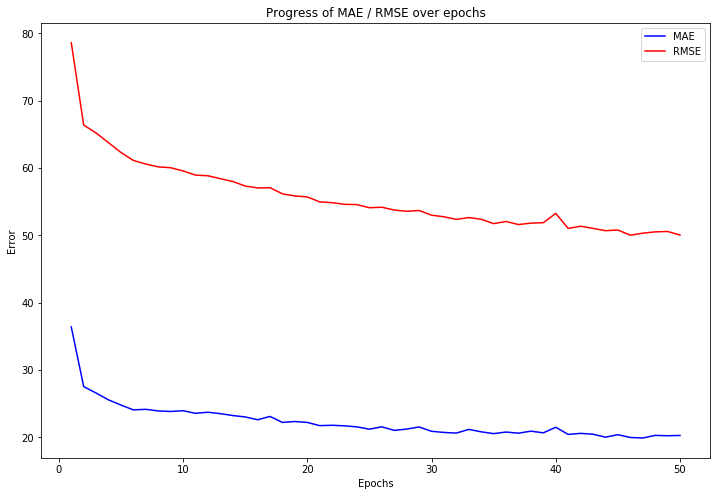

HEX resolution = 5 & period length = 1
ON TRAINING DATA:
MAE  19.894114054657543
MSE  2374.95581686282
R2  0.6116057603113569


ON TEST DATA:
MAE  21.070933962776742
MSE  3244.88752907534
R2  0.5537467356061159


In [37]:
model = build_model()
history = model.fit(X_train_scaled,y_train,epochs=50,batch_size=128,verbose=0)

plt.figure(figsize=(12,8))
mae = history.history['mae']
mse = history.history["mse"]
epochs = range(1, len(mae) + 1)
plt.plot(epochs, mae, 'b', label='MAE')
plt.plot(epochs, np.sqrt(mse), 'r', label="RMSE")
plt.title('Progress of MAE / RMSE over epochs')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

print("HEX resolution = 5 & period length = 1")
pred = model.predict(X_train_scaled)
print("ON TRAINING DATA:")
print("MAE ", mean_absolute_error(y_train,pred))
print("MSE ", mean_squared_error(y_train,pred))
print("R2 ", r2_score(y_train,pred))
print("\n")

pred = model.predict(X_test_scaled)
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

###### Period Length = 2

In [38]:
df = prepareDemandData(hex_resolution=5,periodLength=2)
X = df[["time_basket","month","center_x","center_y","day", "weekend", "weekday", "temperature °C",
              "distanceToCentralStation","distanceToUniversity","distance_next_station", "urban_fabric",
              "industry_commercial", "green_urban_area"]]
y = df[["Demand"]]
X_train , X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

model = build_model()
history = model.fit(X_train_scaled,y_train,epochs=50,batch_size=128,verbose=0)

print("HEX resolution = 5 & period length = 2")
pred = model.predict(X_train_scaled)
print("ON TRAINING DATA:")
print("MAE ", mean_absolute_error(y_train,pred))
print("MSE ", mean_squared_error(y_train,pred))
print("R2 ", r2_score(y_train,pred))
print("\n")

pred = model.predict(X_test_scaled)
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

HEX resolution = 5 & period length = 2
ON TRAINING DATA:
MAE  34.06803249172214
MSE  6739.1099560211605
R2  0.6323533264078172


ON TEST DATA:
MAE  38.69898795289183
MSE  8861.250491584244
R2  0.5776412396759382


###### Period Length = 6

In [39]:
df = prepareDemandData(hex_resolution=5,periodLength=6)
X = df[["time_basket","month","center_x","center_y","day", "weekend", "weekday", "temperature °C",
              "distanceToCentralStation","distanceToUniversity","distance_next_station", "urban_fabric",
              "industry_commercial", "green_urban_area"]]
y = df[["Demand"]]
X_train , X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

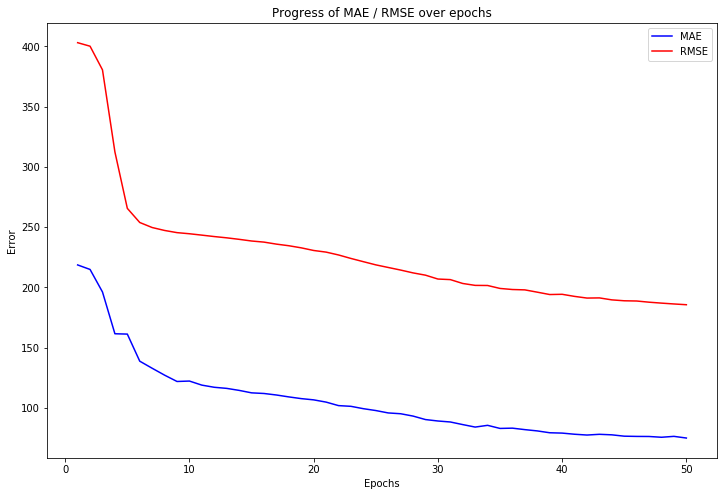

HEX resolution = 5 & period length = 6
ON TRAINING DATA:
MAE  74.20037189318725
MSE  33828.01175021492
R2  0.7047703045961822


ON TEST DATA:
MAE  75.72824134583264
MSE  32137.879491237887
R2  0.7328475379568116


In [40]:
model = build_model()
history = model.fit(X_train_scaled,y_train,epochs=50,batch_size=128,verbose=0)

plt.figure(figsize=(12,8))
mae = history.history['mae']
mse = history.history["mse"]
epochs = range(1, len(mae) + 1)
plt.plot(epochs, mae, 'b', label='MAE')
plt.plot(epochs, np.sqrt(mse), 'r', label="RMSE")
plt.title('Progress of MAE / RMSE over epochs')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

print("HEX resolution = 5 & period length = 6")
pred = model.predict(X_train_scaled)
print("ON TRAINING DATA:")
print("MAE ", mean_absolute_error(y_train,pred))
print("MSE ", mean_squared_error(y_train,pred))
print("R2 ", r2_score(y_train,pred))
print("\n")

pred = model.predict(X_test_scaled)
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

In [41]:
df = prepareDemandData(hex_resolution=5,periodLength=24)
X = df[["time_basket","month","center_x","center_y","day", "weekend", "weekday", "temperature °C",
              "distanceToCentralStation","distanceToUniversity","distance_next_station", "urban_fabric",
              "industry_commercial", "green_urban_area"]]
y = df[["Demand"]]
X_train , X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

model = build_model()
history = model.fit(X_train_scaled,y_train,epochs=50,batch_size=128,verbose=0)

print("HEX resolution = 5 & period length = 24")
pred = model.predict(X_train_scaled)
print("ON TRAINING DATA:")
print("MAE ", mean_absolute_error(y_train,pred))
print("MSE ", mean_squared_error(y_train,pred))
print("R2 ", r2_score(y_train,pred))
print("\n")

pred = model.predict(X_test_scaled)
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

HEX resolution = 5 & period length = 24
ON TRAINING DATA:
MAE  248.85580210794103
MSE  236728.502291015
R2  0.7692264514307923


ON TEST DATA:
MAE  262.4698000785916
MSE  372107.1741866054
R2  0.6813428302586457


### Hexagon resolution = 6

In [42]:
df = prepareDemandData(hex_resolution=6,periodLength=1)
X = df[["time_basket","month","center_x","center_y","day", "weekend", "weekday", "temperature °C",
              "distanceToCentralStation","distanceToUniversity","distance_next_station", "urban_fabric",
              "industry_commercial", "green_urban_area"]]
y = df[["Demand"]]
X_train , X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

model = build_model()
history = model.fit(X_train_scaled,y_train,epochs=50,batch_size=128,verbose=0)

print("HEX resolution = 1 & period length = 1")
pred = model.predict(X_train_scaled)
print("ON TRAINING DATA:")
print("MAE ", mean_absolute_error(y_train,pred))
print("MSE ", mean_squared_error(y_train,pred))
print("R2 ", r2_score(y_train,pred))
print("\n")

pred = model.predict(X_test_scaled)
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

HEX resolution = 1 & period length = 1
ON TRAINING DATA:
MAE  10.339493229034568
MSE  760.3738781031374
R2  0.6837693358790966


ON TEST DATA:
MAE  11.016148714200192
MSE  929.5702707920885
R2  0.5888967479072267


In [43]:
df = prepareDemandData(hex_resolution=6,periodLength=2)
X = df[["time_basket","month","center_x","center_y","day", "weekend", "weekday", "temperature °C",
              "distanceToCentralStation","distanceToUniversity","distance_next_station", "urban_fabric",
              "industry_commercial", "green_urban_area"]]
y = df[["Demand"]]
X_train , X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

model = build_model()
history = model.fit(X_train_scaled,y_train,epochs=50,batch_size=128,verbose=0)

print("HEX resolution = 6 & period length = 2")
pred = model.predict(X_train_scaled)
print("ON TRAINING DATA:")
print("MAE ", mean_absolute_error(y_train,pred))
print("MSE ", mean_squared_error(y_train,pred))
print("R2 ", r2_score(y_train,pred))
print("\n")

pred = model.predict(X_test_scaled)
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

HEX resolution = 6 & period length = 2
ON TRAINING DATA:
MAE  16.047815458439988
MSE  2215.982642899079
R2  0.6939773769453896


ON TEST DATA:
MAE  16.54085075875944
MSE  2010.2129065856666
R2  0.6595018732304897


In [44]:
df = prepareDemandData(hex_resolution=6,periodLength=6)
X = df[["time_basket","month","center_x","center_y","day", "weekend", "weekday", "temperature °C",
              "distanceToCentralStation","distanceToUniversity","distance_next_station", "urban_fabric",
              "industry_commercial", "green_urban_area"]]
y = df[["Demand"]]
X_train , X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

model = build_model()
history = model.fit(X_train_scaled,y_train,epochs=50,batch_size=128,verbose=0)

print("HEX resolution = 6 & period length = 6")
pred = model.predict(X_train_scaled)
print("ON TRAINING DATA:")
print("MAE ", mean_absolute_error(y_train,pred))
print("MSE ", mean_squared_error(y_train,pred))
print("R2 ", r2_score(y_train,pred))
print("\n")

pred = model.predict(X_test_scaled)
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

HEX resolution = 6 & period length = 6
ON TRAINING DATA:
MAE  30.40956344724157
MSE  7876.868312372953
R2  0.8097648962414039


ON TEST DATA:
MAE  34.81740913231219
MSE  10817.037672244829
R2  0.744432580478154


In [45]:
df = prepareDemandData(hex_resolution=6,periodLength=24)
X = df[["time_basket","month","center_x","center_y","day", "weekend", "weekday", "temperature °C",
              "distanceToCentralStation","distanceToUniversity","distance_next_station", "urban_fabric",
              "industry_commercial", "green_urban_area"]]
y = df[["Demand"]]
X_train , X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

model = build_model()
history = model.fit(X_train_scaled,y_train,epochs=50,batch_size=128,verbose=0)

print("HEX resolution = 6 & period length = 24")
pred = model.predict(X_train_scaled)
print("ON TRAINING DATA:")
print("MAE ", mean_absolute_error(y_train,pred))
print("MSE ", mean_squared_error(y_train,pred))
print("R2 ", r2_score(y_train,pred))
print("\n")

pred = model.predict(X_test_scaled)
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

HEX resolution = 6 & period length = 24
ON TRAINING DATA:
MAE  107.87375252520889
MSE  69929.00052922253
R2  0.8351268918864113


ON TEST DATA:
MAE  100.28366170684583
MSE  49978.10947277717
R2  0.8849300075254836


### Hexagon resolution = 7

In [46]:
df = prepareDemandData(hex_resolution=7,periodLength=1)
X = df[["time_basket","month","center_x","center_y","day", "weekend", "weekday", "temperature °C",
              "distanceToCentralStation","distanceToUniversity","distance_next_station", "urban_fabric",
              "industry_commercial", "green_urban_area"]]
y = df[["Demand"]]
X_train , X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

model = build_model()
history = model.fit(X_train_scaled,y_train,epochs=50,batch_size=128,verbose=0)

print("HEX resolution = 7 & period length = 1")
pred = model.predict(X_train_scaled)
print("ON TRAINING DATA:")
print("MAE ", mean_absolute_error(y_train,pred))
print("MSE ", mean_squared_error(y_train,pred))
print("R2 ", r2_score(y_train,pred))
print("\n")

pred = model.predict(X_test_scaled)
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

HEX resolution = 7 & period length = 1
ON TRAINING DATA:
MAE  4.094628254718574
MSE  69.06781725831927
R2  0.607799735890524


ON TEST DATA:
MAE  4.207514933641905
MSE  75.11986638183556
R2  0.4971081774838094


In [47]:
df = prepareDemandData(hex_resolution=7,periodLength=2)
X = df[["time_basket","month","center_x","center_y","day", "weekend", "weekday", "temperature °C",
              "distanceToCentralStation","distanceToUniversity","distance_next_station", "urban_fabric",
              "industry_commercial", "green_urban_area"]]
y = df[["Demand"]]
X_train , X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

model = build_model()
history = model.fit(X_train_scaled,y_train,epochs=50,batch_size=128,verbose=0)

print("HEX resolution = 7 & period length = 2")
pred = model.predict(X_train_scaled)
print("ON TRAINING DATA:")
print("MAE ", mean_absolute_error(y_train,pred))
print("MSE ", mean_squared_error(y_train,pred))
print("R2 ", r2_score(y_train,pred))
print("\n")

pred = model.predict(X_test_scaled)
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

HEX resolution = 7 & period length = 2
ON TRAINING DATA:
MAE  6.502989929109799
MSE  143.83176035638434
R2  0.7030744371043445


ON TEST DATA:
MAE  6.73938234227716
MSE  161.87711793270466
R2  0.6160399439164352


In [48]:
df = prepareDemandData(hex_resolution=7,periodLength=6)
X = df[["time_basket","month","center_x","center_y","day", "weekend", "weekday", "temperature °C",
              "distanceToCentralStation","distanceToUniversity","distance_next_station", "urban_fabric",
              "industry_commercial", "green_urban_area"]]
y = df[["Demand"]]
X_train , X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

model = build_model()
history = model.fit(X_train_scaled,y_train,epochs=50,batch_size=128,verbose=0)

print("HEX resolution = 7 & period length = 6")
pred = model.predict(X_train_scaled)
print("ON TRAINING DATA:")
print("MAE ", mean_absolute_error(y_train,pred))
print("MSE ", mean_squared_error(y_train,pred))
print("R2 ", r2_score(y_train,pred))
print("\n")

pred = model.predict(X_test_scaled)
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

HEX resolution = 7 & period length = 6
ON TRAINING DATA:
MAE  11.991411511940179
MSE  670.3006355182633
R2  0.7561875710089601


ON TEST DATA:
MAE  12.675420091026556
MSE  704.4023107652587
R2  0.7062516345796546


In [49]:
df = prepareDemandData(hex_resolution=7,periodLength=24)
X = df[["time_basket","month","center_x","center_y","day", "weekend", "weekday", "temperature °C",
              "distanceToCentralStation","distanceToUniversity","distance_next_station", "urban_fabric",
              "industry_commercial", "green_urban_area"]]
y = df[["Demand"]]
X_train , X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

model = build_model()
history = model.fit(X_train_scaled,y_train,epochs=50,batch_size=128,verbose=0)

print("HEX resolution = 7 & period length = 24")
pred = model.predict(X_train_scaled)
print("ON TRAINING DATA:")
print("MAE ", mean_absolute_error(y_train,pred))
print("MSE ", mean_squared_error(y_train,pred))
print("R2 ", r2_score(y_train,pred))
print("\n")

pred = model.predict(X_test_scaled)
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

HEX resolution = 7 & period length = 24
ON TRAINING DATA:
MAE  30.52197719744063
MSE  3832.4887202883697
R2  0.8379550368765151


ON TEST DATA:
MAE  31.215040605641004
MSE  3994.4452082372127
R2  0.8282020192369401


### Hexagon resolution = 8

In [50]:
df = prepareDemandData(hex_resolution=8,periodLength=1)
X = df[["time_basket","month","center_x","center_y","day", "weekend", "weekday", "temperature °C",
              "distanceToCentralStation","distanceToUniversity","distance_next_station", "urban_fabric",
              "industry_commercial", "green_urban_area"]]
y = df[["Demand"]]
X_train , X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

model = build_model()
history = model.fit(X_train_scaled,y_train,epochs=50,batch_size=128,verbose=0)

print("HEX resolution = 8 & period length = 1")
pred = model.predict(X_train_scaled)
print("ON TRAINING DATA:")
print("MAE ", mean_absolute_error(y_train,pred))
print("MSE ", mean_squared_error(y_train,pred))
print("R2 ", r2_score(y_train,pred))
print("\n")

pred = model.predict(X_test_scaled)
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

HEX resolution = 8 & period length = 1
ON TRAINING DATA:
MAE  1.51143593167555
MSE  7.928855924393645
R2  0.48522917835411306


ON TEST DATA:
MAE  1.572394561655714
MSE  9.48658773583006
R2  0.3834818284824345


In [51]:
df = prepareDemandData(hex_resolution=8,periodLength=2)
X = df[["time_basket","month","center_x","center_y","day", "weekend", "weekday", "temperature °C",
              "distanceToCentralStation","distanceToUniversity","distance_next_station", "urban_fabric",
              "industry_commercial", "green_urban_area"]]
y = df[["Demand"]]
X_train , X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

model = build_model()
history = model.fit(X_train_scaled,y_train,epochs=50,batch_size=128,verbose=0)

print("HEX resolution = 8 & period length = 2")
pred = model.predict(X_train_scaled)
print("ON TRAINING DATA:")
print("MAE ", mean_absolute_error(y_train,pred))
print("MSE ", mean_squared_error(y_train,pred))
print("R2 ", r2_score(y_train,pred))
print("\n")

pred = model.predict(X_test_scaled)
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

HEX resolution = 8 & period length = 2
ON TRAINING DATA:
MAE  2.099100122169144
MSE  12.971099769165665
R2  0.6491724766561267


ON TEST DATA:
MAE  2.172075991592443
MSE  16.1027200687247
R2  0.5876866256971698


In [52]:
df = prepareDemandData(hex_resolution=8,periodLength=6)
X = df[["time_basket","month","center_x","center_y","day", "weekend", "weekday", "temperature °C",
              "distanceToCentralStation","distanceToUniversity","distance_next_station", "urban_fabric",
              "industry_commercial", "green_urban_area"]]
y = df[["Demand"]]
X_train , X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

model = build_model()
history = model.fit(X_train_scaled,y_train,epochs=50,batch_size=128,verbose=0)

print("HEX resolution = 8 & period length = 6")
pred = model.predict(X_train_scaled)
print("ON TRAINING DATA:")
print("MAE ", mean_absolute_error(y_train,pred))
print("MSE ", mean_squared_error(y_train,pred))
print("R2 ", r2_score(y_train,pred))
print("\n")

pred = model.predict(X_test_scaled)
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

HEX resolution = 8 & period length = 6
ON TRAINING DATA:
MAE  3.9260768072690997
MSE  45.6822495767511
R2  0.7435304876680277


ON TEST DATA:
MAE  4.117212563294823
MSE  57.523277258453376
R2  0.6804451159972595


In [53]:
df = prepareDemandData(hex_resolution=8,periodLength=24)
X = df[["time_basket","month","center_x","center_y","day", "weekend", "weekday", "temperature °C",
              "distanceToCentralStation","distanceToUniversity","distance_next_station", "urban_fabric",
              "industry_commercial", "green_urban_area"]]
y = df[["Demand"]]
X_train , X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

model = build_model()
history = model.fit(X_train_scaled,y_train,epochs=50,batch_size=128,verbose=0)

print("HEX resolution = 8 & period length = 24")
pred = model.predict(X_train_scaled)
print("ON TRAINING DATA:")
print("MAE ", mean_absolute_error(y_train,pred))
print("MSE ", mean_squared_error(y_train,pred))
print("R2 ", r2_score(y_train,pred))
print("\n")

pred = model.predict(X_test_scaled)
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

HEX resolution = 8 & period length = 24
ON TRAINING DATA:
MAE  8.71575235891063
MSE  257.15358037286495
R2  0.8056998200761565


ON TEST DATA:
MAE  9.160467968334641
MSE  338.0159943803135
R2  0.7438565840412434


### Hexagon resolution = 9

In [54]:
df = prepareDemandData(hex_resolution=9,periodLength=1)
X = df[["time_basket","month","center_x","center_y","day", "weekend", "weekday", "temperature °C",
              "distanceToCentralStation","distanceToUniversity","distance_next_station", "urban_fabric",
              "industry_commercial", "green_urban_area"]]
y = df[["Demand"]]
X_train , X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

model = build_model()
history = model.fit(X_train_scaled,y_train,epochs=50,batch_size=128,verbose=0)

print("HEX resolution = 9 & period length = 1")
pred = model.predict(X_train_scaled)
print("ON TRAINING DATA:")
print("MAE ", mean_absolute_error(y_train,pred))
print("MSE ", mean_squared_error(y_train,pred))
print("R2 ", r2_score(y_train,pred))
print("\n")

pred = model.predict(X_test_scaled)
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

HEX resolution = 9 & period length = 1
ON TRAINING DATA:
MAE  0.6851599091969194
MSE  1.3003346522521133
R2  0.389304539807542


ON TEST DATA:
MAE  0.6951312608845714
MSE  1.3940805362162
R2  0.339204735764587


In [55]:
df = prepareDemandData(hex_resolution=9,periodLength=2)
X = df[["time_basket","month","center_x","center_y","day", "weekend", "weekday", "temperature °C",
              "distanceToCentralStation","distanceToUniversity","distance_next_station", "urban_fabric",
              "industry_commercial", "green_urban_area"]]
y = df[["Demand"]]
X_train , X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

model = build_model()
history = model.fit(X_train_scaled,y_train,epochs=50,batch_size=128,verbose=0)

print("HEX resolution = 9 & period length = 2")
pred = model.predict(X_train_scaled)
print("ON TRAINING DATA:")
print("MAE ", mean_absolute_error(y_train,pred))
print("MSE ", mean_squared_error(y_train,pred))
print("R2 ", r2_score(y_train,pred))
print("\n")

pred = model.predict(X_test_scaled)
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

HEX resolution = 9 & period length = 2
ON TRAINING DATA:
MAE  0.8798831162031383
MSE  2.3154485702146608
R2  0.48388896559526895


ON TEST DATA:
MAE  0.8956477546400344
MSE  2.529627947300802
R2  0.4190011578047229


In [56]:
df = prepareDemandData(hex_resolution=9,periodLength=6)
X = df[["time_basket","month","center_x","center_y","day", "weekend", "weekday", "temperature °C",
              "distanceToCentralStation","distanceToUniversity","distance_next_station", "urban_fabric",
              "industry_commercial", "green_urban_area"]]
y = df[["Demand"]]
X_train , X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

model = build_model()
history = model.fit(X_train_scaled,y_train,epochs=50,batch_size=128,verbose=0)

print("HEX resolution = 9 & period length = 6")
pred = model.predict(X_train_scaled)
print("ON TRAINING DATA:")
print("MAE ", mean_absolute_error(y_train,pred))
print("MSE ", mean_squared_error(y_train,pred))
print("R2 ", r2_score(y_train,pred))
print("\n")

pred = model.predict(X_test_scaled)
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

HEX resolution = 9 & period length = 6
ON TRAINING DATA:
MAE  1.4730535160994238
MSE  6.685718037466168
R2  0.5827794585396773


ON TEST DATA:
MAE  1.5094850426886843
MSE  7.270291200249497
R2  0.5293702621327379


In [57]:
df = prepareDemandData(hex_resolution=9,periodLength=24)
X = df[["time_basket","month","center_x","center_y","day", "weekend", "weekday", "temperature °C",
              "distanceToCentralStation","distanceToUniversity","distance_next_station", "urban_fabric",
              "industry_commercial", "green_urban_area"]]
y = df[["Demand"]]
X_train , X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

model = build_model()
history = model.fit(X_train_scaled,y_train,epochs=50,batch_size=128,verbose=0)

print("HEX resolution = 9 & period length = 24")
pred = model.predict(X_train_scaled)
print("ON TRAINING DATA:")
print("MAE ", mean_absolute_error(y_train,pred))
print("MSE ", mean_squared_error(y_train,pred))
print("R2 ", r2_score(y_train,pred))
print("\n")

pred = model.predict(X_test_scaled)
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

HEX resolution = 9 & period length = 24
ON TRAINING DATA:
MAE  2.9765274781960076
MSE  23.95536820441921
R2  0.7078428032841908


ON TEST DATA:
MAE  3.1021300865816595
MSE  27.98669726630116
R2  0.6498057549239774
